In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import math
from pyproj import Geod
from geopy.geocoders import Nominatim
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
sns.set()

In [2]:
#Dataset load
ds_train = pd.read_csv(r'..\Data\Original\train.zip' , compression="zip")

## Dataset description

Data fields
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server -  Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

# Data exploration

In [3]:
ds_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
ds_train.shape

(1458644, 11)

Dataset dimentions: 1458644 row, 11 attributes

In [5]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
ds_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [7]:
#to_datetime columns
ds_train['pickup_datetime'] = pd.to_datetime(ds_train.pickup_datetime)
ds_train['dropoff_datetime'] = pd.to_datetime(ds_train.dropoff_datetime)
ds_train.loc[:, 'pickup_date'] = ds_train['pickup_datetime'].dt.date

In [8]:
#add columns to split datetimes
ds_train['month_pickup'] = [date.month for date in ds_train.pickup_datetime]
ds_train['day_pickup'] = [date.day for date in ds_train.pickup_datetime]
ds_train['dow_pickup'] = [date.dayofweek for date in ds_train.pickup_datetime]
ds_train['hour_pickup'] = [date.hour for date in ds_train.pickup_datetime]

#### Time period in analysis

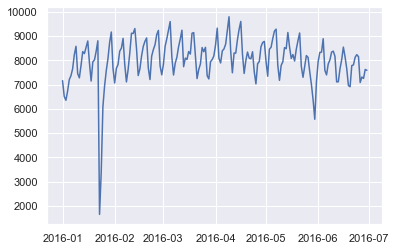

In [9]:
#time period in analysis
pyplot.plot(ds_train.groupby("pickup_date").count()[["vendor_id"]])

Time period: 6 month, from 01-2016 to 07-2016<br>
From this plot I can spot a deep decrease in the number of drives during late january

In [10]:
#from sec to min trip_duration
ds_train['min_trip_duration'] = [sec//60 for sec in ds_train.trip_duration]

#### Time duration per day of the week

<AxesSubplot:xlabel='dow_pickup', ylabel='trip_duration'>

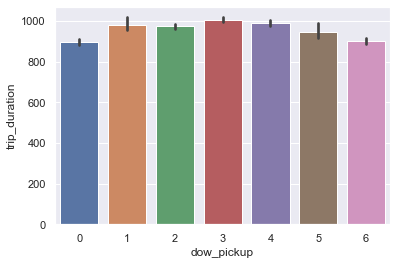

In [11]:
# bar plot of time duration in min per day
sns.barplot(data=ds_train, y="trip_duration", x="dow_pickup")

Trip duration changes based on day of the week <br>
Minor decrese during week end and monday

#### Trip duration study

<AxesSubplot:ylabel='min_trip_duration'>

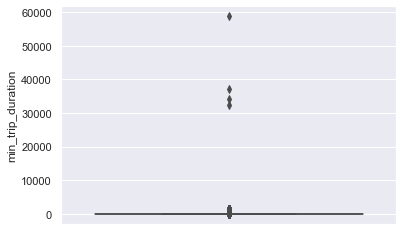

In [12]:
# violin plot of distribution time duration in min
sns.boxplot(y=ds_train["min_trip_duration"])

<AxesSubplot:xlabel='trip_duration', ylabel='Probability'>

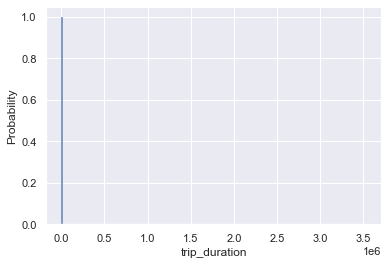

In [13]:
sns.histplot(data=ds_train, x="trip_duration", bins=200, stat="probability")

Outliers to remove

In [14]:
# number of trips that lasted more than 13 hours
ds_train[ds_train["min_trip_duration"]>(60*13)]["id"].count()

1985

Since trips lasting longer than 13 hours constitute only 0.1% of the dataset (1985 rows), I will proceed to eliminate them

In [15]:
# percentage of records with duration longer then 2hrs
ds_train[ds_train["min_trip_duration"]>=180]["id"].count() / ds_train["id"].count()

0.0014479201230732104

Since the number of records with time duration more than 2hrs is insignificant (0.1 %) I will proceed with the removal

#### Number of passengers study

<AxesSubplot:xlabel='passenger_count', ylabel='min_trip_duration'>

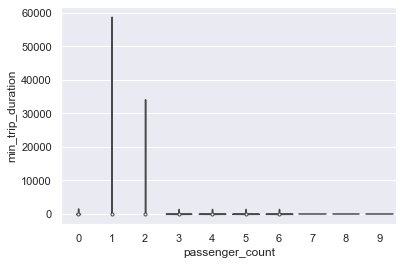

In [16]:
#violin plot with trip duration in min and number of passengers
sns.violinplot(y=ds_train["min_trip_duration"], x=ds_train["passenger_count"])

Wrong values (0 passengers)

In [17]:
# percentage of records with more then 7 passengers
ds_train[ds_train["passenger_count"]>=7]["id"].count() / ds_train["id"].count()

3.4278412004574113e-06

Since the number of records with more than 6 passengers is insignificant (3^-4 %) I will proceed with the removal

#### Study of pickup location

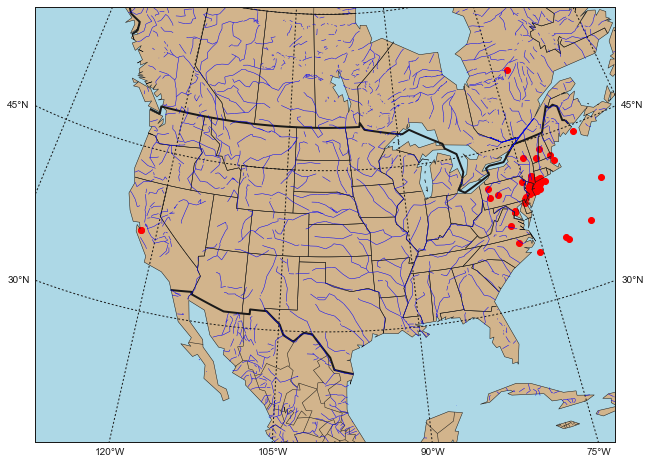

In [18]:
os.environ['PROJ_LIB'] = '/Users/mb/anaconda3/envs/worklab/share/proj'
from mpl_toolkits.basemap import Basemap
fig = plt.figure(num=None, figsize=(12, 8) ) 
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lat_1=35.,lat_2=45,lon_0=-100,lat_0=40)
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,15.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

m.scatter(ds_train.pickup_longitude.array, ds_train.pickup_latitude.array, latlon=True, marker='o', color='Red') 

In [21]:
import fiona
ny_map = gpd.read_file(r'..\Data\CHS_2009_DOHMH_2010B.shp')
fig, ax = plt.subplots(figsize = (15,15))
ny_map.plot(ax=ax)

AttributeError: partially initialized module 'fiona' has no attribute '_loading' (most likely due to a circular import)

I need to remove all the starting points outside of new york

#### Distribution of pickup hour of the day

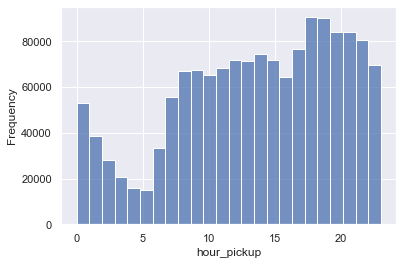

In [ ]:
#distribution of hours of the day pickup
sns.histplot(data=ds_train, x="hour_pickup", bins=24)
plt.gca().set( ylabel='Frequency');

# Outliers

Removal of all trips that lasted more than 3hours

In [ ]:
ds_train_noOutlier = ds_train[ds_train["min_trip_duration"]<(60*3)]

Removal of all trips that have 0 passengers or more than 6

In [ ]:
ds_train_noOutlier = ds_train_noOutlier[ds_train_noOutlier["passenger_count"]>0]

In [ ]:
ds_train_noOutlier = ds_train_noOutlier[ds_train_noOutlier["passenger_count"]<=6]

Removal of all starting point outside NY

In [ ]:
from tqdm import tqdm
geolocator = Nominatim(user_agent="geoapiExercises")
def is_in_NY(Longitude, Latitude):
    if(Latitude>41.215372 ):
        return "T"
    else:
        return Latitude

tqdm.pandas()
ds_train_noOutlier["city"] = ds_train_noOutlier.progress_apply(lambda x: is_in_NY(x["pickup_longitude"], x["pickup_latitude"]), axis=1)


100%|██████████| 1456468/1456468 [00:30<00:00, 47183.07it/s]


In [ ]:
ds_train_noOutlier.groupby("city")["id"].count()

city
34.35969543457031      1
34.71223449707031      1
35.0815315246582       1
35.310306549072266     1
36.02930068969727      1
                      ..
41.16782379150391      1
41.189956665039055     1
41.194454193115234     1
41.211158752441406     1
T                     21
Name: id, Length: 45203, dtype: int64

##### Percentage or record removal

In [ ]:
1 - (ds_train_noOutlier["id"].count() / ds_train["id"].count())

0.0014479201230732652

Percentage of records deleted after clearing outiler: 0.1%

# Feature extraction 

Columns added:
- dow_pickup, day of the week of the pickup
- distance, total distance calculated with difference between pickup lat. long. and dropoff lat. long.
- zone, geographical zone calculate with clustering algorithm

#### Distance from starting point to finishing point

In [ ]:
wgs84_geod = Geod(ellps='WGS84')

#Get distance between pairs of lat-lon points
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
  return dist

#Create test data
lat1 = ds_train_noOutlier.pickup_latitude
lon1 = ds_train_noOutlier.pickup_longitude
lat2 = ds_train_noOutlier.dropoff_latitude
lon2 = ds_train_noOutlier.dropoff_latitude

#Package as a dataframe
df = pd.DataFrame({'lat1':lat1,'lon1':lon1,'lat2':lat2,'lon2':lon2})

#Add/update a column to the data frame with the distances (in metres)
ds_train_noOutlier['dist'] = Distance(df['lat1'].tolist(),df['lon1'].tolist(),df['lat2'].tolist(),df['lon2'].tolist())                               

#### Cluster algorithm based on start location to extract the zone

# Feature selection

# Final data summary

In [ ]:
ds_train_noOutlier.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month_pickup,day_pickup,dow_pickup,hour_pickup,min_trip_duration
count,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06,1.456468e+06
mean,1.534291e+00,1.663986e+00,-7.397349e+01,4.075093e+01,-7.397342e+01,4.075180e+01,8.368253e+02,3.516784e+00,1.550401e+01,3.049950e+00,1.360663e+01,1.345637e+01
std,4.988229e-01,1.313550e+00,7.091102e-02,3.286402e-02,7.067243e-02,3.588669e-02,6.584766e+02,1.681028e+00,8.702933e+00,1.954021e+00,6.399269e+00,1.097804e+01
min,1.000000e+00,1.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073736e+01,-7.399133e+01,4.073589e+01,3.970000e+02,2.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00,6.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075453e+01,6.620000e+02,4.000000e+00,1.500000e+01,3.000000e+00,1.400000e+01,1.100000e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396302e+01,4.076981e+01,1.073000e+03,5.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01,1.700000e+01
max,2.000000e+00,6.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.073100e+04,6.000000e+00,3.100000e+01,6.000000e+00,2.300000e+01,1.780000e+02


<AxesSubplot:xlabel='passenger_count', ylabel='min_trip_duration'>

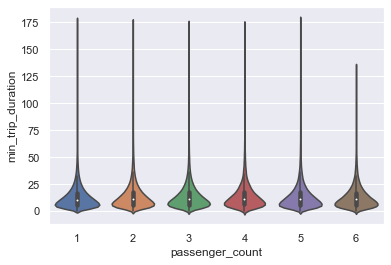

In [ ]:
#violin plot with trip duration in min and number of passengers
sns.violinplot(y=ds_train_noOutlier["min_trip_duration"], x=ds_train_noOutlier["passenger_count"])

<AxesSubplot:xlabel='dow_pickup', ylabel='min_trip_duration'>

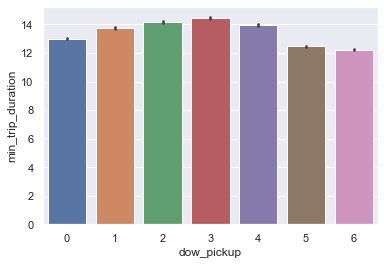

In [ ]:
# bar plot of time duration in min per day
sns.barplot(data=ds_train_noOutlier, y="min_trip_duration", x="dow_pickup")

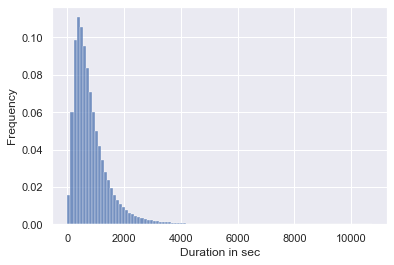

In [ ]:
#distribution of trips duration
sns.histplot(data=ds_train_noOutlier, x="trip_duration", bins=100, stat="probability")
plt.gca().set( ylabel='Frequency', xlabel="Duration in sec");